In [59]:
# %pip install xgboost

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
titanic = sns.load_dataset('titanic')

titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [4]:
titanic['is_female'] = np.where(titanic['sex'] == 'female', 1, 0)

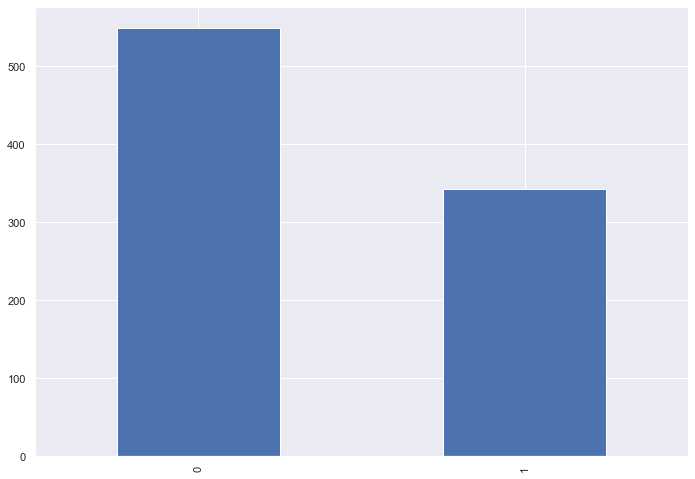

In [5]:
titanic.survived.value_counts().plot(kind='bar');

In [6]:
round(titanic.survived.value_counts(normalize=True)*100, 2)

0    61.62
1    38.38
Name: survived, dtype: float64

In [7]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,is_female
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,0
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,1
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,1
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,1
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,0


In [8]:
keep = ['pclass', 'is_female', 'age', 'sibsp', 'parch', 'fare']

X = titanic.loc[:, keep]
y = titanic.loc[:, 'survived']

In [9]:
# Train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.33, 
                                                    random_state=RANDOM_STATE,
                                                    stratify=y)

In [10]:
# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(random_state=RANDOM_STATE)

# Inspect the parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

There's a couple of things to note:
- The `booster` parameter is `gbtree`.  This means the weak learners, or boosters, are decision trees in this model. `gbtree` is the default, and we will keep it this way.
- The `objective` function, or loss function, is defined as `binary:logistic`. The objective function quantifies how far off a prediction is from the actual results. We want to minimize this to have the smallest possible loss. `binary:logistic` is the default for classifiers. `binary:logistic` outputs the actual predicted probability of the positive class (in our case, that a booking is cancelled).
- `n_estimators` is the number of gradient boosted trees we want in our model. It's equivalent to the number of boosting rounds. For our purposes, we don't want too many boosting rounds, or training will take too long. **Let's lower it from 100 to 10**.
- `max_depth` is the maximum tree depth allowed. Tree depth is the length of the longest path from the root node to a leaf node. Making this too high will give our model more variance, or more potential to overfit. Similar to `n_estimators`, the more we increase this, the longer our training period will be. **Let's keep this at 3**.
- For our `eval_metric` (evaluation metric for validation data), we will use `error` as defined by [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):

> Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.


[0]	validation_0-logloss:0.55005	validation_1-logloss:0.57270


/home/evan/anaconda3/envs/boosting/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10]	validation_0-logloss:0.27736	validation_1-logloss:0.42600
[20]	validation_0-logloss:0.21689	validation_1-logloss:0.44684
[30]	validation_0-logloss:0.17670	validation_1-logloss:0.46303
[40]	validation_0-logloss:0.15237	validation_1-logloss:0.50037
[50]	validation_0-logloss:0.13690	validation_1-logloss:0.52260
[60]	validation_0-logloss:0.12251	validation_1-logloss:0.54312
[70]	validation_0-logloss:0.11442	validation_1-logloss:0.56003
[80]	validation_0-logloss:0.10767	validation_1-logloss:0.57548
[90]	validation_0-logloss:0.10150	validation_1-logloss:0.58651
[99]	validation_0-logloss:0.09651	validation_1-logloss:0.59738
The accuracy score for XGBClassifier is: 0.7864406779661017


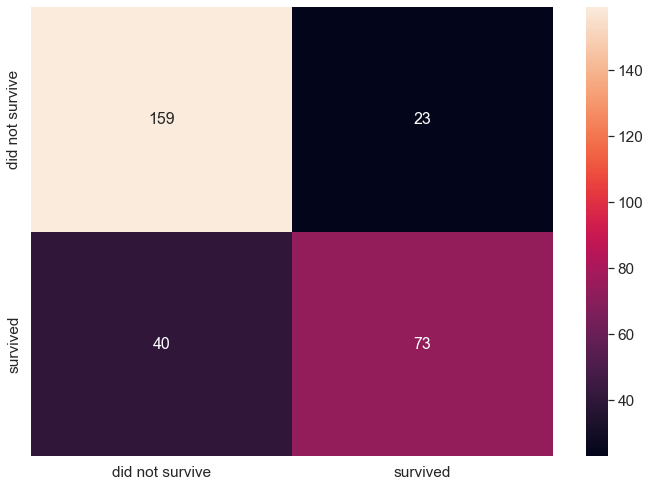

In [11]:
xgb_clf.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), 
                      (X_test, y_test)],
            eval_metric='logloss',
            verbose=10)

preds = xgb_clf.predict(X_test)

print(f'The accuracy score for XGBClassifier is:', xgb_clf.score(X_test,y_test))

cm_array = confusion_matrix(y_test, preds, labels=[0,1])


label_names = ['did not survive', 'survived']

df_cm = pd.DataFrame(cm_array, 
                     index=label_names, 
                     columns=label_names)

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16}); # font size

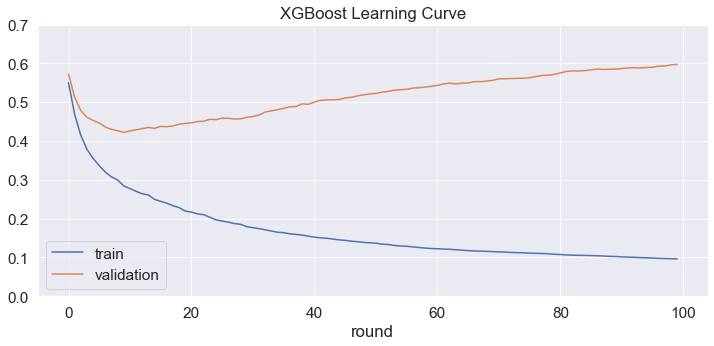

In [13]:
#Plot the Learning Curve
evals_result = xgb_clf.evals_result()

train_errors = evals_result['validation_0']['logloss']

validation_errors = evals_result['validation_1']['logloss']

df = pd.DataFrame([train_errors, validation_errors]).T

df.columns = ['train', 'validation']

df.index.name = 'round'

df.plot(title='XGBoost Learning Curve', ylim=(0, 0.7), figsize=(12, 5));

In [14]:
params = {'n_estimators': 20, 
         'max_depth': 20,
         'eval_metric': 'logloss',
         'random_state': RANDOM_STATE,
         'use_label_encoder': False,
         'booster': 'gbtree',}


# Instatiate a XGBClassifier 
xgb_clf = xgb.XGBClassifier(**params)

# Inspect the parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': 'gbtree',
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': 20,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 20,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eval_metric': 'logloss'}

[0]	validation_0-logloss:0.54378	validation_1-logloss:0.57548
[10]	validation_0-logloss:0.22182	validation_1-logloss:0.44250
[19]	validation_0-logloss:0.15457	validation_1-logloss:0.49346
The accuracy score for XGBClassifier is: 0.8033898305084746


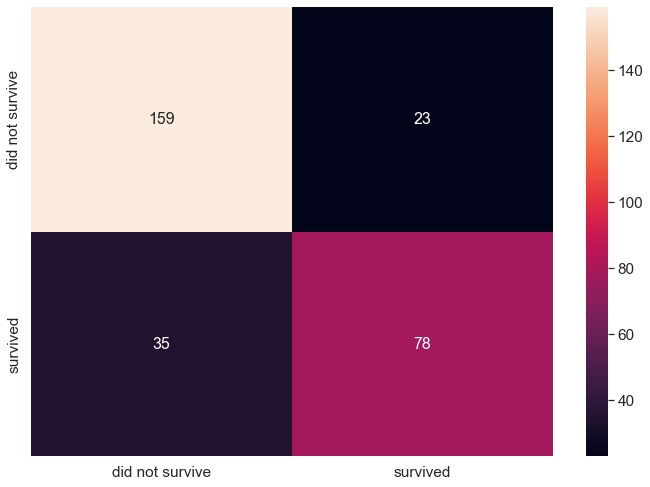

In [15]:
xgb_clf.fit(X_train, 
            y_train,
            eval_set=[(X_train, y_train), 
                      (X_test, y_test)],
            eval_metric='logloss',
            verbose=10)

preds = xgb_clf.predict(X_test)

print(f'The accuracy score for XGBClassifier is:', xgb_clf.score(X_test,y_test))

cm_array = confusion_matrix(y_test, preds, labels=[0,1])


label_names = ['did not survive', 'survived']

df_cm = pd.DataFrame(cm_array, 
                     index=label_names, 
                     columns=label_names)

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16}); # font size

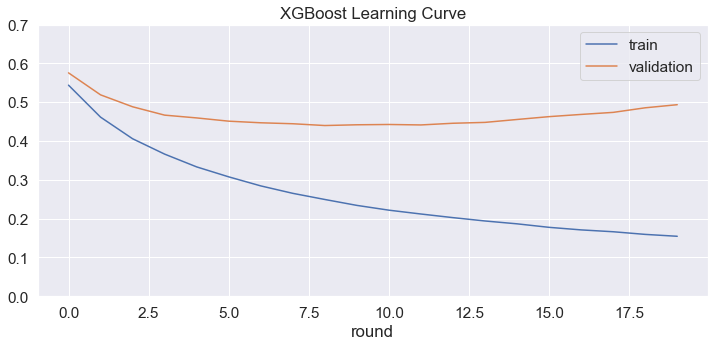

In [16]:
#Plot the Learning Curve
evals_result = xgb_clf.evals_result()

train_errors = evals_result['validation_0']['logloss']

validation_errors = evals_result['validation_1']['logloss']

df = pd.DataFrame([train_errors, validation_errors]).T

df.columns = ['train', 'validation']

df.index.name = 'round'

df.plot(title='XGBoost Learning Curve', ylim=(0, 0.7), figsize=(12, 5));

In [17]:
# Visualizing the importance of the features
xgb_clf.get_booster().get_score(importance_type='weight')

{'pclass': 31.0,
 'is_female': 23.0,
 'age': 330.0,
 'sibsp': 35.0,
 'parch': 24.0,
 'fare': 351.0}

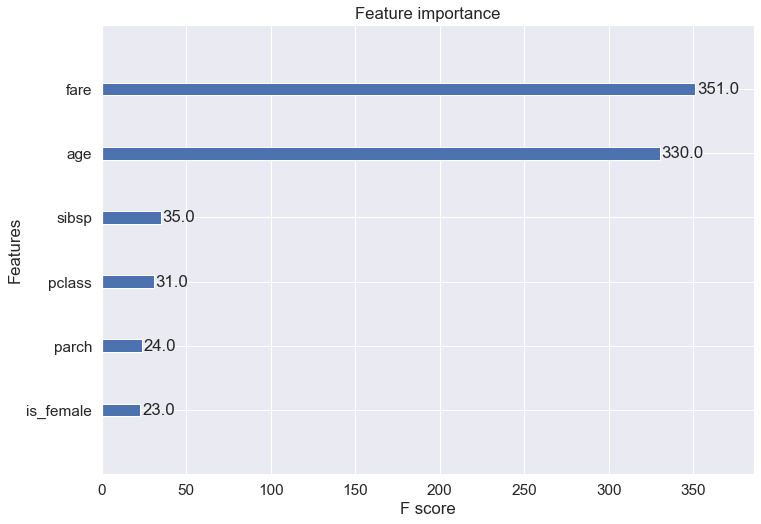

In [18]:
# How many times a feature appears in a tree
xgb.plot_importance(xgb_clf, importance_type='weight', max_num_features=10);

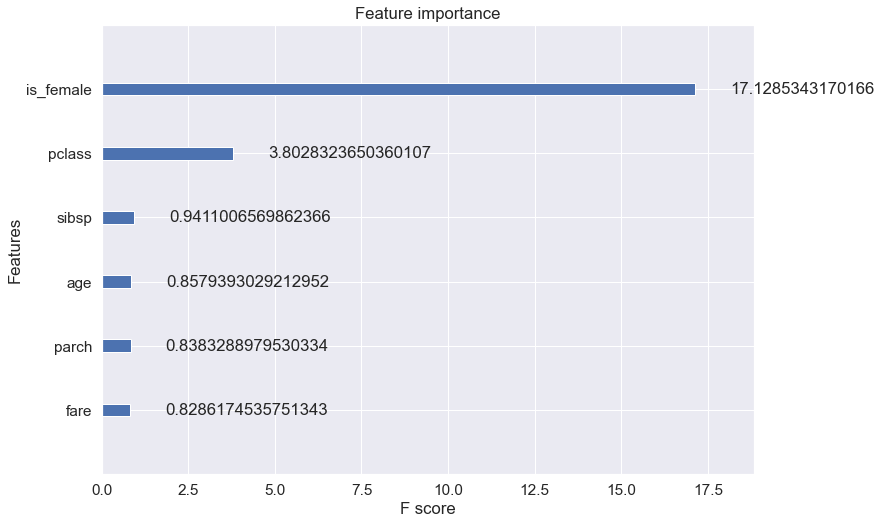

In [19]:
# What is the average gain of splits for each feature?
xgb.plot_importance(xgb_clf, importance_type='gain', max_num_features=10);

How is importance calculated? Here's an excerpt from the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting):

> **importance_type (str, default "weight") –**
> How the importance is calculated: either “weight”, “gain”, or “cover”
> - ”weight” is the number of times a feature appears in a tree
> - ”gain” is the average gain of splits which use the feature
> - ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

We'll focus on the first two. Gain is a way to quantify how much a feature contributes to improving accuracy. Let's try out `gain` to see how it differs from `weight`.